In [1]:
import collections

import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt

import parser

In [2]:
events, level_sequence = parser.read_events("userlogs/p2")

In [3]:
graphs = parser.only_complete_graphs(parser.get_state_graphs(level_sequence[75]))

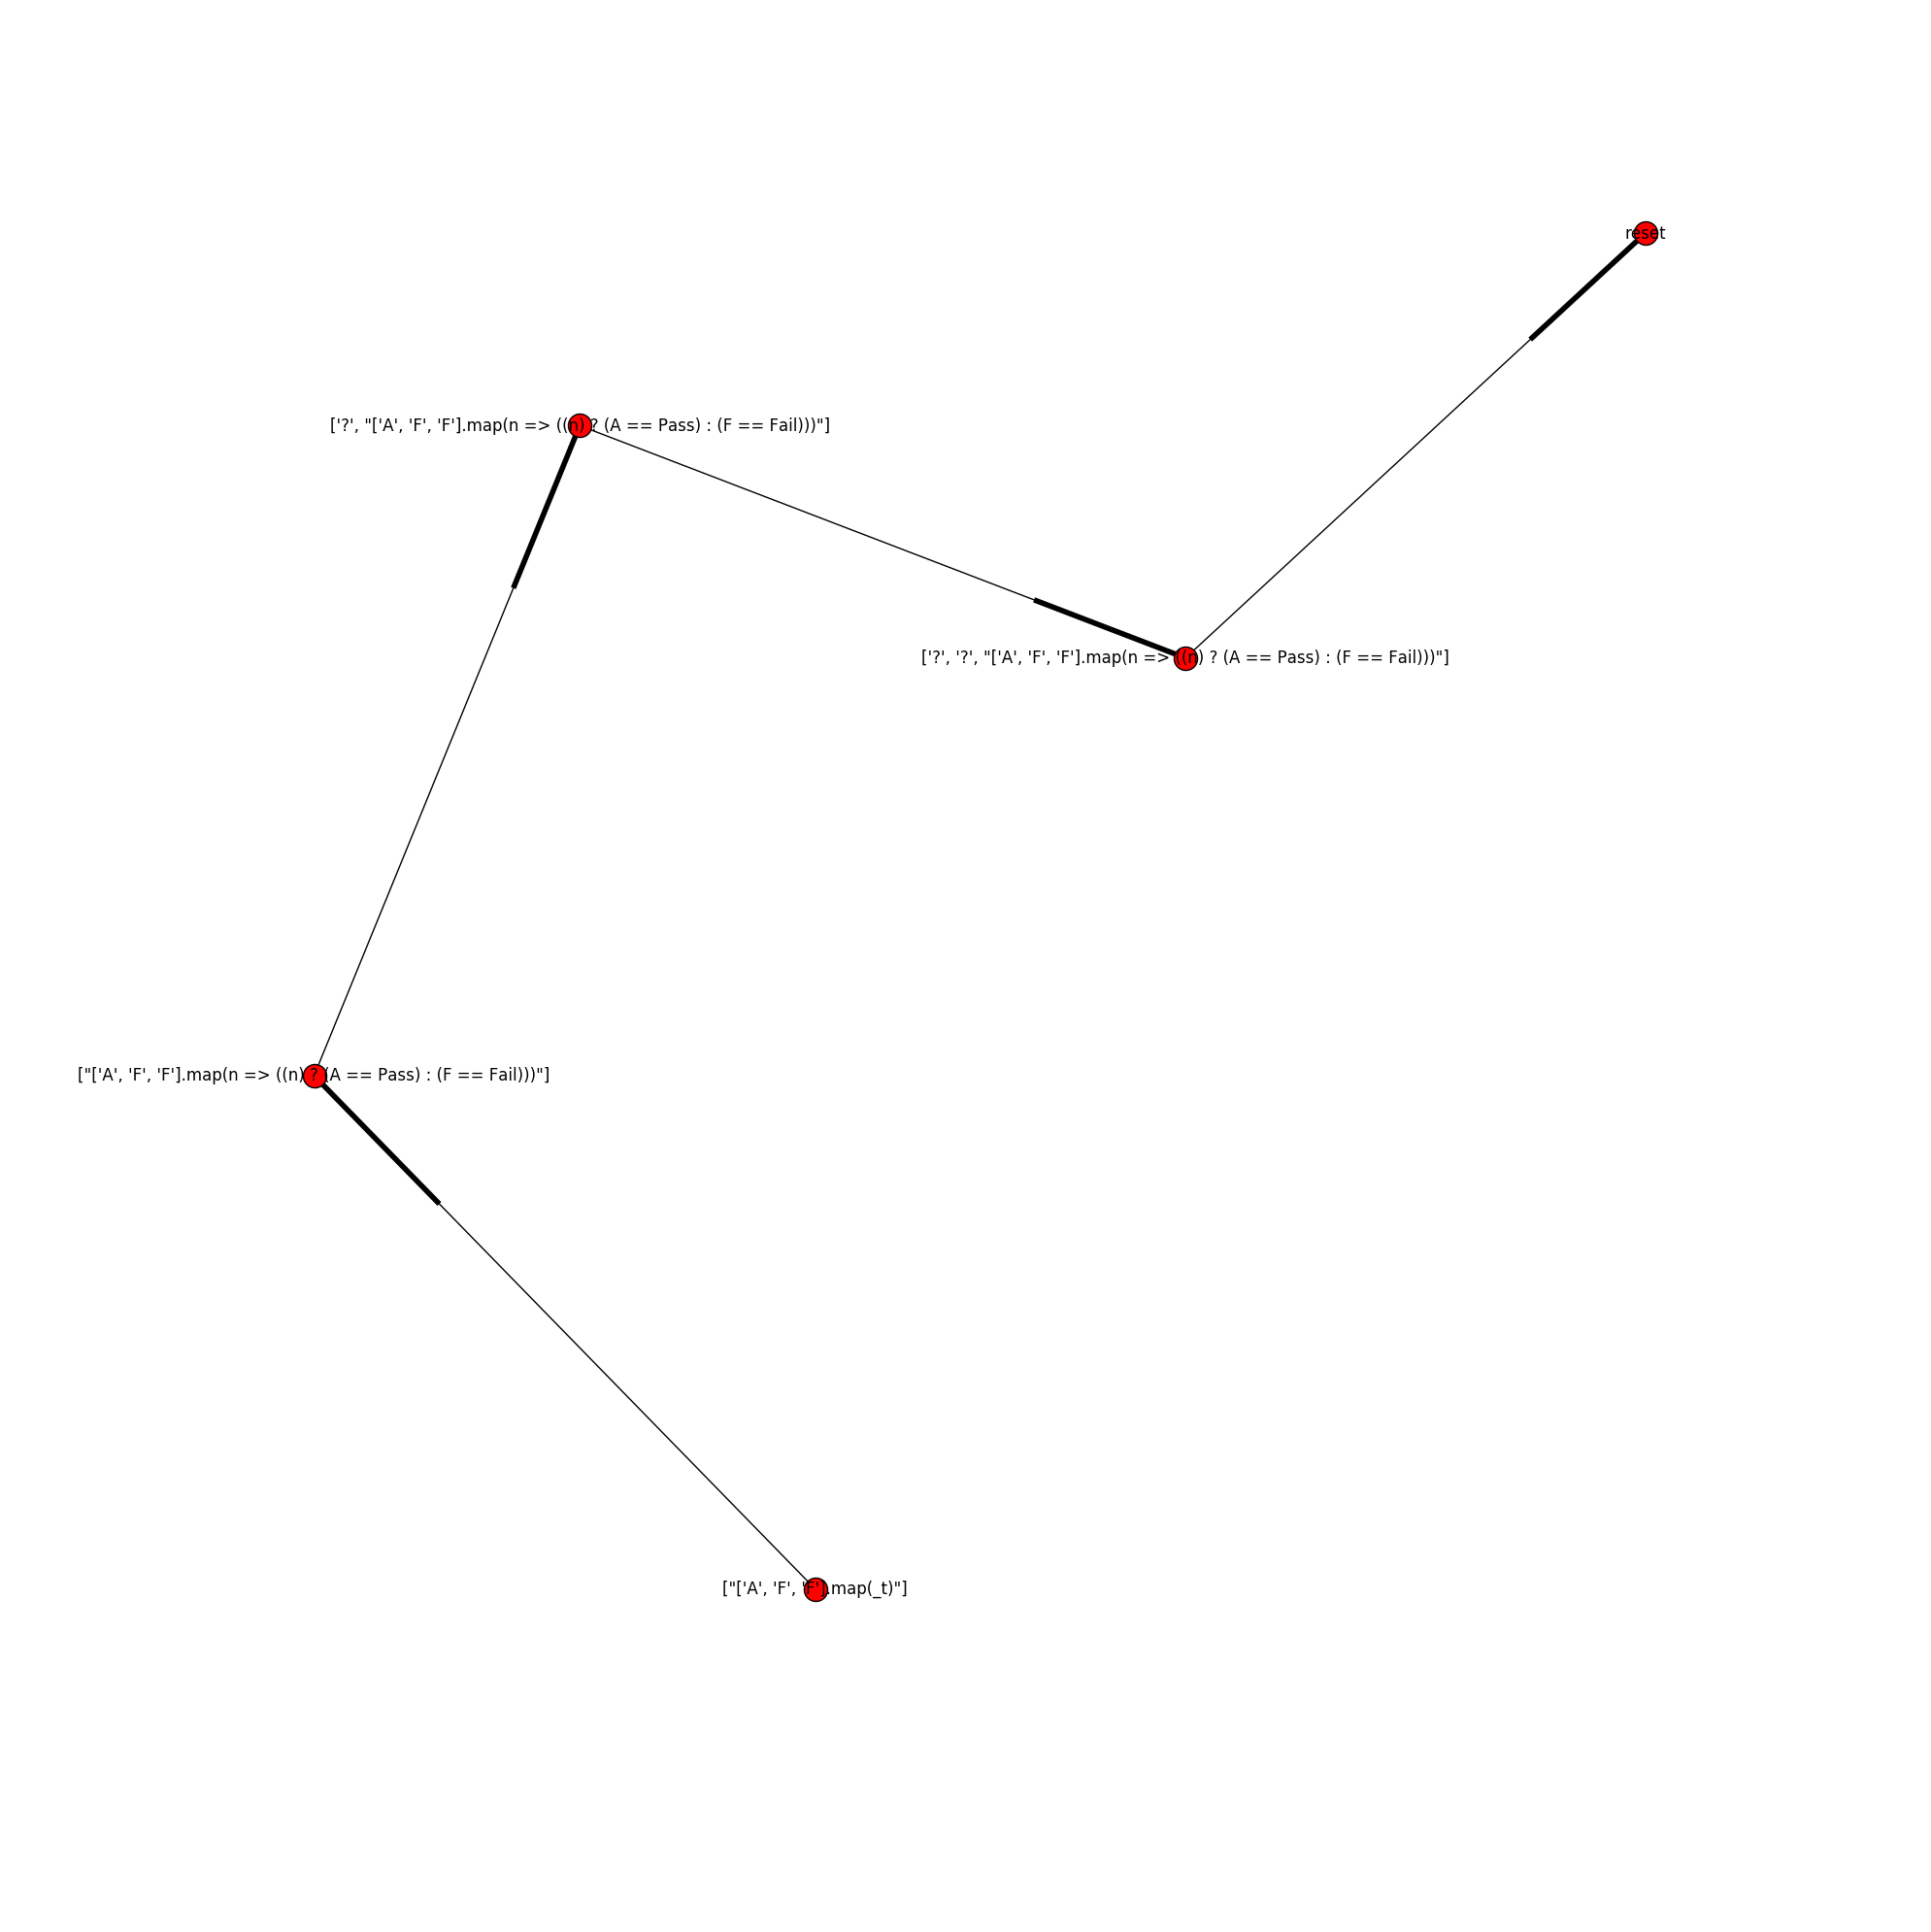

In [4]:
parser.draw_graph(graphs[0])

In [ ]:
parser.draw_graph(parser.get_complete_merged_graph(level_sequence, 65), size=(25, 25))

In [ ]:
parser.draw_graph(parser.get_complete_merged_graph(level_sequence, 25), size=(25, 25))

### Vis.js graph visualization
Note: you *must* add vis.js to your static paths in your jupyter notebook config file. Please see [this tutorial](https://www.codementor.io/isaib.cicourel/visjs-visualization-in-jupyter-notebook-phgb3fjv0) for details.

*(Eventually we will wrap this module in a .js file and also add it to static paths, but for now the logic is not finished yet.)*

In [35]:
# Convert some graph data into a JSON string
from networkx.readwrite import json_graph
import json
graph_to_json = lambda G: json.dumps(json_graph.node_link_data(G))
# test_data = graph_to_json(graphs[0])

merged = parser.get_complete_merged_graph(level_sequence, 56)
test_data = graph_to_json(merged)

# Pass graph data to JS backend
from IPython.display import Javascript
js = "window.graph_data={};".format(test_data)
Javascript(js)

<IPython.core.display.Javascript object>

In [37]:
%%javascript

/* Converts the networkx output (serialized through JSON) 
*  to vis.js format. */
function nx_to_vis(G) {
    
    // Convert nodes from nx format into vis.js format:
    var nodes = G["nodes"].map(function(n, idx) {
        return { id: idx, label: n["id"] };
    });
    
    // Convert edges ('links') to vis.js format:
    var edges = G["links"].map(function(e) {
        var r = { from: e["source"], to: e["target"] };
        if ("count" in e) r.label = "" + e.count;
        return r;
    });
    
    return {
        nodes: nodes,
        edges: edges
    };
}

require.config({
    paths: {
        vis: 'vis'
    }
});

require(['vis'], function(vis){
    
    // (a weird idempotency thing)
    $("#net1").remove();
    
    // Create an element to put the network into
    element.append("<div id='net1' style='border:solid 1px'></div>");
    
    // Load the JSON graph we sent from Python.
    var graph_json = window.graph_data;
    
    // Decode it to vis.js format:
    var data = nx_to_vis(graph_json);

    // Create the network
    var container = document.getElementById('net1');
    var options = {
        width: '800px',
        height: '400px',
        nodes: {
            shape: 'box'
        },
        edges: {
            arrows: 'to'
        }
    };
    var network = new vis.Network(container, data, options);
});

<IPython.core.display.Javascript object>